# Stats shots parquet exploration

This notebook loads a parquet file produced by `stats_shots_to_parquet.py` from the `output/analytics` directory and shows basic time-series plots for ticks, creature count, and key genes.



In [49]:
import os
from pathlib import Path

import pandas as pd

# Heuristic: this notebook lives under `<repo_root>/analysis`, and parquet files
# live under `<repo_root>/output/analytics`, so the project root is the parent
# directory of the current working directory.
PROJECT_ROOT = Path.cwd().parent
ANALYTICS_DIR = PROJECT_ROOT / "output" / "analytics"

parquet_files = sorted(ANALYTICS_DIR.glob("*.parquet"))

if not parquet_files:
    raise FileNotFoundError(f"No parquet files found under {ANALYTICS_DIR}. Run stats_shots_to_parquet.py from the repo root first.")

# Choose which file to load (by index into the list above)
FILE_INDEX = 0  # adjust this if you want a different file

selected_path = parquet_files[FILE_INDEX]

In [50]:
# Load the selected parquet file and show available ticks

df = pd.read_parquet(selected_path)

if "tick" not in df.columns:
    raise KeyError("Column 'tick' not found in parquet file.")

unique_ticks = sorted(df["tick"].dropna().unique())


In [51]:
# Print colony ID in a large title font
from IPython.display import display, HTML, Markdown  # pyright: ignore[reportMissingImports]

# Check if colony_id exists in the dataframe
if "colony_id" in df.columns:
    colony_id = df["colony_id"].iloc[0] if len(df) > 0 else "Unknown"
    # Use HTML for large title display
    display(HTML(f'<h1 style="font-size: 48px; font-weight: bold; text-align: center; margin: 20px 0;">Colony ID: {colony_id}</h1>'))
elif "colony_instance_id" in df.columns:
    colony_id = df["colony_instance_id"].iloc[0] if len(df) > 0 else "Unknown"
    display(HTML(f'<h1 style="font-size: 48px; font-weight: bold; text-align: center; margin: 20px 0;">Colony ID: {colony_id}</h1>'))
else:
    # Try to extract from filename as fallback
    colony_id = selected_path.stem
    display(HTML(f'<h1 style="font-size: 48px; font-weight: bold; text-align: center; margin: 20px 0;">Colony ID: {colony_id}</h1>'))

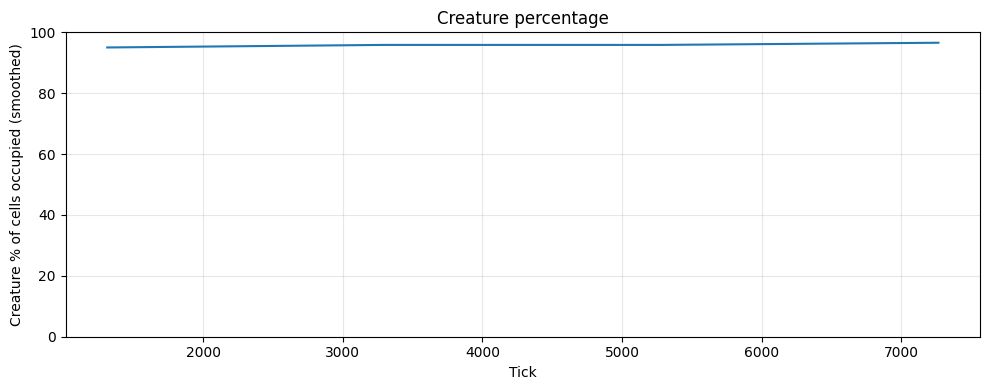

In [52]:
# Plot creature percentage over time (tick on X axis), with a smoothed curve

import matplotlib.pyplot as plt  # pyright: ignore[reportMissingImports]

required_cols = {"creatures_count", "colony_width", "colony_height"}
missing = required_cols - set(df.columns)
if missing:
    raise KeyError(
        f"Missing columns {missing} in parquet file. "
        "Regenerate parquet with updated stats_shots_to_parquet.py to include colony_width/colony_height."
    )

# Sort by tick to ensure a sensible time series
plot_df = df.sort_values("tick").copy()

# Compute percentage of grid cells occupied by creatures
plot_df["grid_cells"] = plot_df["colony_width"] * plot_df["colony_height"]
plot_df["creature_pct"] = (plot_df["creatures_count"] / plot_df["grid_cells"]) * 100.0

# Compute a rolling mean to smooth the line (adjust window size as desired)
window = 5  # number of points in the smoothing window
plot_df["creature_pct_smooth"] = plot_df["creature_pct"].rolling(window=window, min_periods=1, center=True).mean()

plt.figure(figsize=(10, 4))
plt.plot(
    plot_df["tick"],
    plot_df["creature_pct_smooth"],
    linestyle="-",
    linewidth=1.5,
)
plt.xlabel("Tick")
plt.ylabel("Creature % of cells occupied (smoothed)")
plt.title("Creature percentage")
plt.ylim(0, 100)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



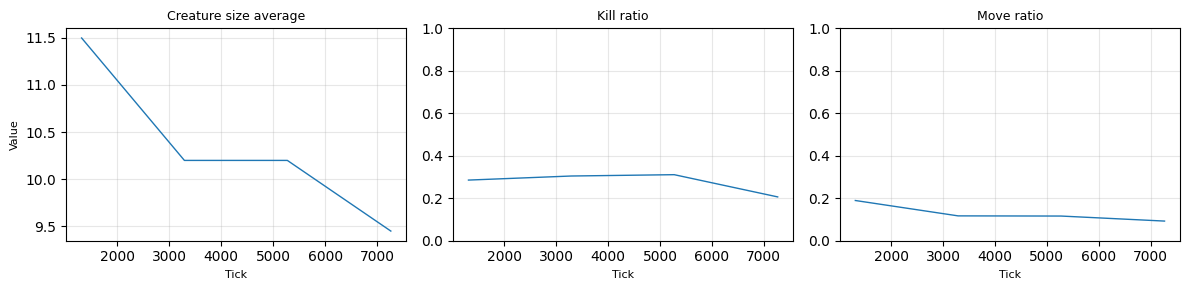

In [53]:
# Compact view: 3 charts horizontally (creature size avg, kill ratio, move ratio)

import matplotlib.pyplot as plt  # pyright: ignore[reportMissingImports]

plot_df = df.sort_values("tick").copy()

fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharex=False)

# 1) Numerical gene: creature_size_avg (or creature_size_mean fallback)
y_col_creature = None
if "creature_size_avg" in plot_df.columns:
    y_col_creature = "creature_size_avg"
elif "creature_size_mean" in plot_df.columns:
    y_col_creature = "creature_size_mean"

if y_col_creature is not None:
    window = 5  # smoothing window size
    smooth_col = f"{y_col_creature}_smooth"
    plot_df[smooth_col] = plot_df[y_col_creature].rolling(window=window, min_periods=1, center=True).mean()
    axes[0].plot(plot_df["tick"], plot_df[smooth_col], linewidth=1)
    axes[0].set_title("Creature size average", fontsize=9)
    axes[0].set_xlabel("Tick", fontsize=8)
    axes[0].set_ylabel("Value", fontsize=8)
    axes[0].grid(True, alpha=0.3)
else:
    axes[0].text(0.5, 0.5, "Creature size average not found", ha="center", va="center", fontsize=8)

# 2) Boolean gene: can_kill_true_fraction
if "can_kill_true_fraction" in plot_df.columns:
    axes[1].plot(plot_df["tick"], plot_df["can_kill_true_fraction"], linewidth=1)
    axes[1].set_title("Kill ratio", fontsize=9)
    axes[1].set_xlabel("Tick", fontsize=8)
    axes[1].set_ylim(0, 1)
    axes[1].grid(True, alpha=0.3)
else:
    axes[1].text(0.5, 0.5, "Kill ratio not found", ha="center", va="center", fontsize=8)

# 3) Boolean gene: can_move_true_fraction
if "can_move_true_fraction" in plot_df.columns:
    axes[2].plot(plot_df["tick"], plot_df["can_move_true_fraction"], linewidth=1)
    axes[2].set_title("Move ratio", fontsize=9)
    axes[2].set_xlabel("Tick", fontsize=8)
    axes[2].set_ylim(0, 1)
    axes[2].grid(True, alpha=0.3)
else:
    axes[2].text(0.5, 0.5, "Move ratio not found", ha="center", va="center", fontsize=8)

plt.tight_layout()
plt.show()



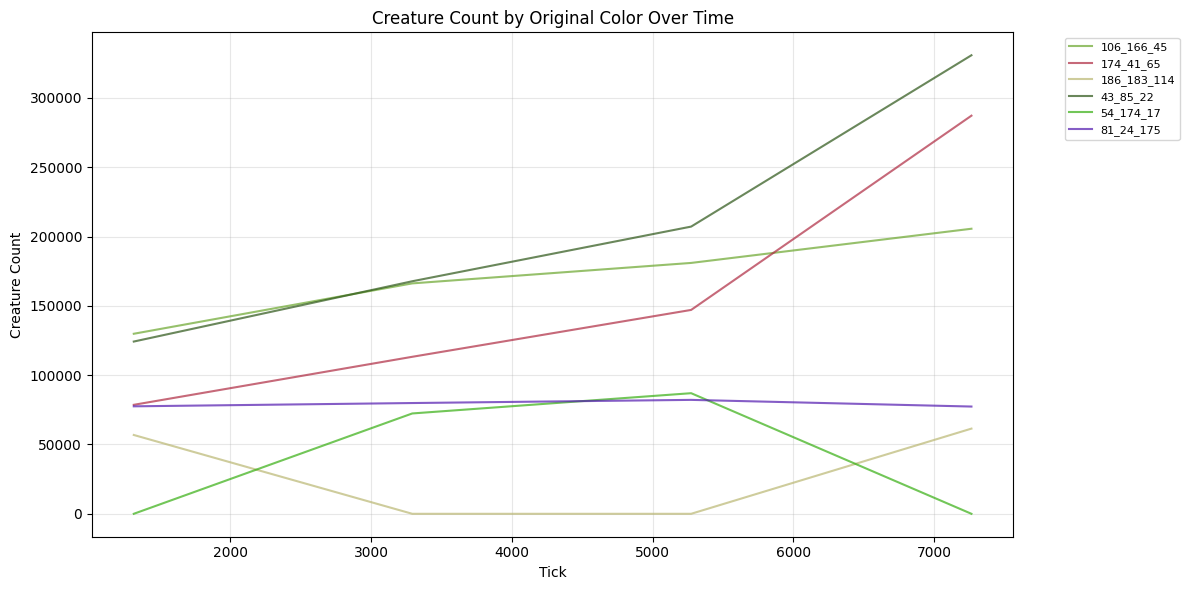

In [54]:
# Plot creature count by tick, colored by original color RGB
# Each curve represents creatures with a specific original color, colored by that color's RGB values

import matplotlib.pyplot as plt  # pyright: ignore[reportMissingImports]

plot_df = df.sort_values("tick").copy()

# Collect all unique original colors from top N columns across all ticks
all_colors = set()
for i in range(1, 6):  # top 1-5
    col_name = f"original_color_top{i}"
    if col_name in plot_df.columns:
        colors = plot_df[col_name].dropna().unique()
        all_colors.update(colors)

if not all_colors:
    print("No original_color data found in parquet file. Regenerate parquet with updated stats_shots_to_parquet.py.")
else:
    # For each color, track its count over time
    color_data = {}
    for color_str in all_colors:
        color_data[color_str] = []
    
    # Extract counts for each color at each tick
    for _, row in plot_df.iterrows():
        tick = row["tick"]
        for color_str in all_colors:
            count = None
            # Check top 1-5 columns for this color
            for i in range(1, 6):
                top_col = f"original_color_top{i}"
                count_col = f"original_color_top{i}_count"
                if top_col in row and row[top_col] == color_str:
                    if count_col in row:
                        count = row[count_col]
                    break
            color_data[color_str].append((tick, count if count is not None else 0))
    
    # Plot each color as a separate curve
    plt.figure(figsize=(12, 6))
    
    for color_str in sorted(all_colors):
        # Parse RGB values from color string (format: "R_G_B")
        try:
            parts = color_str.split("_")
            if len(parts) == 3:
                r = int(parts[0]) / 255.0
                g = int(parts[1]) / 255.0
                b = int(parts[2]) / 255.0
                rgb_color = (r, g, b)
            else:
                rgb_color = (0.5, 0.5, 0.5)  # Default gray if parsing fails
        except (ValueError, IndexError):
            rgb_color = (0.5, 0.5, 0.5)  # Default gray if parsing fails
        
        # Extract ticks and counts for this color
        ticks = [t for t, _ in color_data[color_str]]
        counts = [c for _, c in color_data[color_str]]
        
        # Only plot if there's at least one non-zero count
        if any(c > 0 for c in counts):
            plt.plot(ticks, counts, label=color_str, color=rgb_color, linewidth=1.5, alpha=0.7)
    
    plt.xlabel("Tick")
    plt.ylabel("Creature Count")
    plt.title("Creature Count by Original Color Over Time")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()



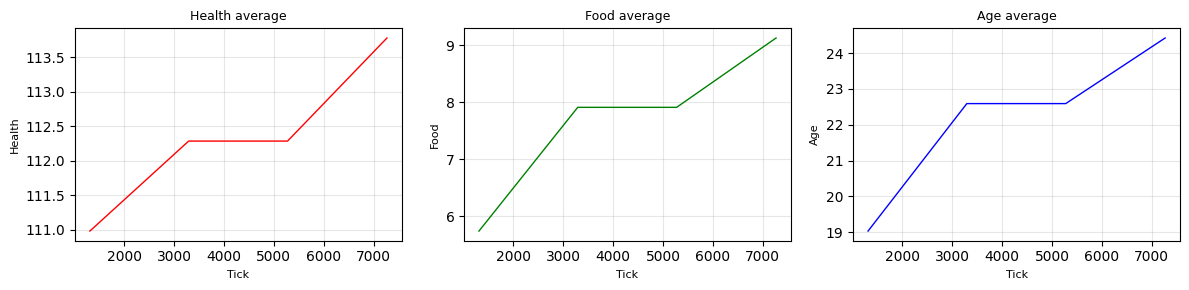

In [55]:
# New metrics: Health, Food, and Age - 3 charts horizontally

import matplotlib.pyplot as plt  # pyright: ignore[reportMissingImports]

plot_df = df.sort_values("tick").copy()

fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharex=True)

window = 5  # smoothing window size

# 1) Health average
y_col_health = None
if "health_avg" in plot_df.columns:
    y_col_health = "health_avg"
elif "health_mean" in plot_df.columns:
    y_col_health = "health_mean"

if y_col_health is not None:
    smooth_col = f"{y_col_health}_smooth"
    plot_df[smooth_col] = plot_df[y_col_health].rolling(window=window, min_periods=1, center=True).mean()
    axes[0].plot(plot_df["tick"], plot_df[smooth_col], linewidth=1, color="red")
    axes[0].set_title("Health average", fontsize=9)
    axes[0].set_xlabel("Tick", fontsize=8)
    axes[0].set_ylabel("Health", fontsize=8)
    axes[0].grid(True, alpha=0.3)
else:
    axes[0].text(0.5, 0.5, "Health average not found", ha="center", va="center", fontsize=8)

# 2) Food average
y_col_food = None
if "food_avg" in plot_df.columns:
    y_col_food = "food_avg"
elif "food_mean" in plot_df.columns:
    y_col_food = "food_mean"

if y_col_food is not None:
    smooth_col = f"{y_col_food}_smooth"
    plot_df[smooth_col] = plot_df[y_col_food].rolling(window=window, min_periods=1, center=True).mean()
    axes[1].plot(plot_df["tick"], plot_df[smooth_col], linewidth=1, color="green")
    axes[1].set_title("Food average", fontsize=9)
    axes[1].set_xlabel("Tick", fontsize=8)
    axes[1].set_ylabel("Food", fontsize=8)
    axes[1].grid(True, alpha=0.3)
else:
    axes[1].text(0.5, 0.5, "Food average not found", ha="center", va="center", fontsize=8)

# 3) Age average
y_col_age = None
if "age_avg" in plot_df.columns:
    y_col_age = "age_avg"
elif "age_mean" in plot_df.columns:
    y_col_age = "age_mean"

if y_col_age is not None:
    smooth_col = f"{y_col_age}_smooth"
    plot_df[smooth_col] = plot_df[y_col_age].rolling(window=window, min_periods=1, center=True).mean()
    axes[2].plot(plot_df["tick"], plot_df[smooth_col], linewidth=1, color="blue")
    axes[2].set_title("Age average", fontsize=9)
    axes[2].set_xlabel("Tick", fontsize=8)
    axes[2].set_ylabel("Age", fontsize=8)
    axes[2].grid(True, alpha=0.3)
else:
    axes[2].text(0.5, 0.5, "Age average not found", ha="center", va="center", fontsize=8)

plt.tight_layout()
plt.show()
